<a href="https://colab.research.google.com/github/fboldt/aulas-am-bsi/blob/main/aula13a_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
dataset = load_iris()
X = dataset.data[:,2:]
y = dataset.target

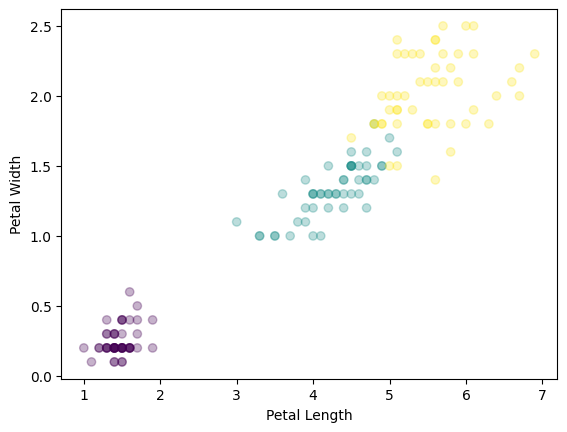

In [7]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y,alpha=0.3)
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()

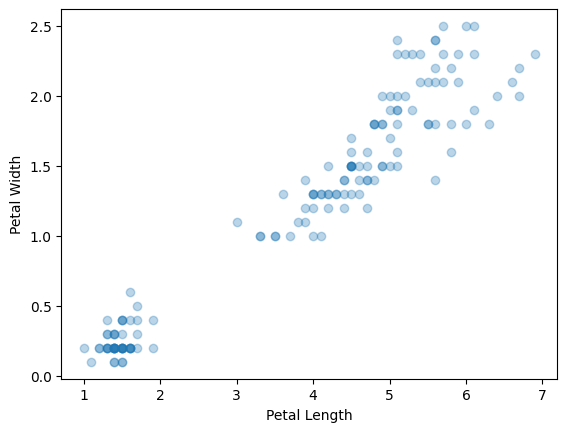

In [8]:
plt.scatter(X[:,0],X[:,1],alpha=0.3)
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()

[[1.462      0.246     ]
 [5.62608696 2.04782609]
 [4.29259259 1.35925926]]


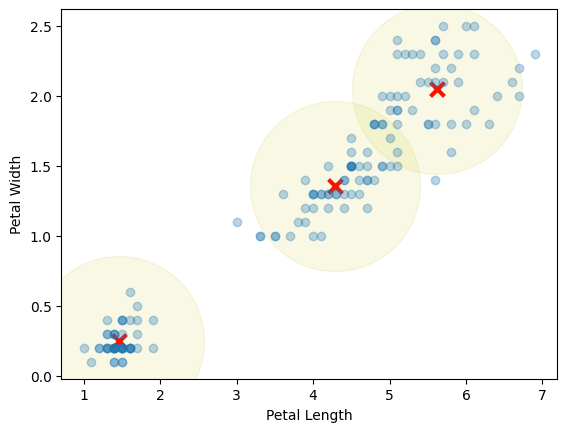

In [42]:
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
import numpy as np


class KMeans(BaseEstimator, ClusterMixin, TransformerMixin):
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X, y=None):
        self.centroids_ = X[np.random.choice(len(X), self.n_clusters)]
        self.previous_centroids = [self.centroids_.copy()]
        while self.max_iter > 0:
          self.max_iter -= 1
          ypred = self.predict(X)
          for i in range(self.n_clusters):
            self.centroids_[i] = X[ypred == i].mean(axis=0)
          if np.allclose(self.centroids_, self.previous_centroids[-1]):
            break
          self.previous_centroids.append(self.centroids_.copy())
        self.centroids_ = np.array(self.centroids_)
        return self

    def distances(self, x):
        diferences = self.centroids_ - x
        squared = np.square(diferences)
        summed = np.sum(squared, axis=1)
        root = np.sqrt(summed)
        return root

    def predict(self, X):
        ypred = np.empty((X.shape[0],))
        for i, x in enumerate(X):
            distances = self.distances(x)
            centroid = np.argmin(distances)
            ypred[i] = centroid
        return ypred


kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
print(kmeans.centroids_)

centroids = kmeans.centroids_
plt.scatter(centroids[:,0],centroids[:,1],
            marker='x', color='r', s=100, linewidths=3)
plt.scatter(centroids[:,0],centroids[:,1],
            marker='o', color='y', s=15000, alpha=0.1)
plt.scatter(X[:,0],X[:,1],alpha=0.3)
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()

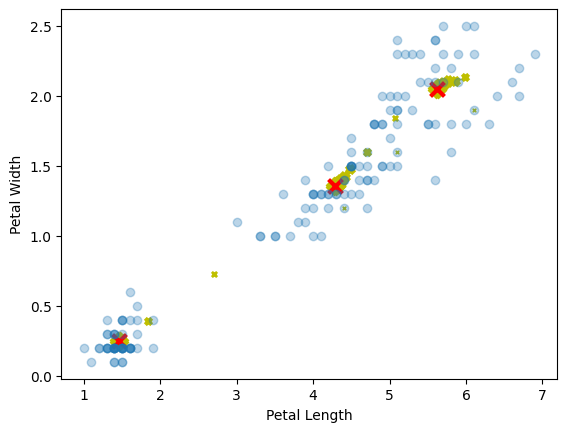

In [43]:
for i in range(len(kmeans.previous_centroids)):
    centroids = np.array(kmeans.previous_centroids[i])
    plt.scatter(centroids[:,0],centroids[:,1],
                marker='x', color='y', s=7*(i+1), linewidths=i+1)
centroids = kmeans.centroids_
plt.scatter(centroids[:,0],centroids[:,1],
            marker='x', color='r', s=100, linewidths=3)
plt.scatter(X[:,0],X[:,1],alpha=0.3)
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()

In [38]:
def define_axes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

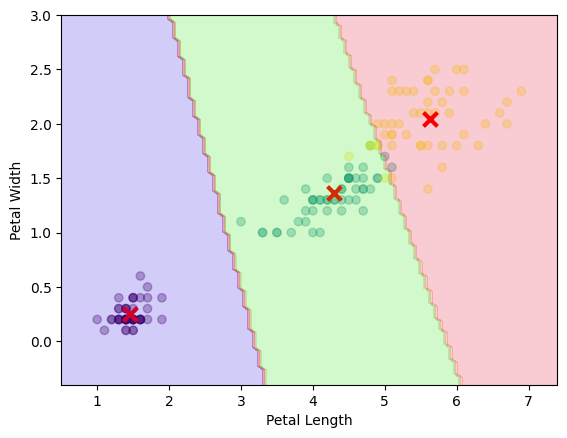

In [44]:
plt.scatter(X[:,0],X[:,1],c=y,alpha=0.3)
plt.scatter(centroids[:,0],centroids[:,1],
            marker='x', color='r', s=100, linewidths=3)
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plot_predictions(kmeans, X)
plt.show()